In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
import coco_text

In [2]:
ct = coco_text.COCO_Text('cocotext.v2.json')

loading annotations into memory...
0:00:01.693554
creating index...
index created!


In [3]:
from detectron2.structures import BoxMode

def get_coco_dict(img_dir,d):
    dataset_dicts = []
    if d.find('train') !=-1:
        imgIds = ct.getImgIds(imgIds=ct.train, catIds=[('legibility','legible')])
    elif d.find('val') != -1:
        imgIds = ct.getImgIds(imgIds=ct.val, catIds=[('legibility','legible')])
    for ids in imgIds:
        record = {}
        img = ct.loadImgs(ids)[0]
        filename = os.path.join(img_dir, img["file_name"])        
        record["file_name"] = filename
        record["image_id"] = ids
        record["height"] = img['height']
        record["width"] = img['width']
      
        annoIds = ct.getAnnIds(imgIds = ids)
        annos = ct.loadAnns(annoIds)
        objs = []
        for anno in annos:
            obj = {
                "bbox": anno['bbox'],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": 0 if anno['language']=='english' else 1,
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train2014", "val2014"]:
    DatasetCatalog.register("coco_text_" + d, lambda d=d: get_coco_dict("/coco/train2014/",d))
    MetadataCatalog.get("coco_text_" + d).set(thing_classes=["english","others",])
coco_text_metadata = MetadataCatalog.get("coco_text_train2014")

In [4]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("coco_text_train2014",)
cfg.DATASETS.TEST = ("coco_text_val2014",)
cfg.DATALOADER.NUM_WORKERS = 8
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 8
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 1500   
cfg.SOLVER.STEPS = []        
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2

In [5]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[12/13 18:28:41 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[12/13 18:28:43 d2.engine.train_loop]: Starting training from iteration 0


/ext3/miniconda3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/ext3/miniconda3/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/13 18:29:05 d2.utils.events]:  eta: 0:21:22  iter: 19  total_loss: 4.034  loss_cls: 1.265  loss_box_reg: 0.04177  loss_rpn_cls: 2.378  loss_rpn_loc: 0.3295  time: 0.8518  data_time: 0.1408  lr: 4.9953e-06  max_mem: 9433M
[12/13 18:29:22 d2.utils.events]:  eta: 0:21:04  iter: 39  total_loss: 3.618  loss_cls: 1.156  loss_box_reg: 0.04172  loss_rpn_cls: 2.058  loss_rpn_loc: 0.3035  time: 0.8590  data_time: 0.0096  lr: 9.9902e-06  max_mem: 9434M
[12/13 18:29:39 d2.utils.events]:  eta: 0:20:47  iter: 59  total_loss: 2.927  loss_cls: 1.014  loss_box_reg: 0.0657  loss_rpn_cls: 1.579  loss_rpn_loc: 0.2884  time: 0.8637  data_time: 0.0098  lr: 1.4985e-05  max_mem: 9434M
[12/13 18:29:57 d2.utils.events]:  eta: 0:20:32  iter: 79  total_loss: 2.267  loss_cls: 0.8096  loss_box_reg: 0.0802  loss_rpn_cls: 1.054  loss_rpn_loc: 0.3079  time: 0.8661  data_time: 0.0096  lr: 1.998e-05  max_mem: 9434M
[12/13 18:30:15 d2.utils.events]:  eta: 0:20:21  iter: 99  total_loss: 1.663  loss_cls: 0.6393  loss_b

In [6]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

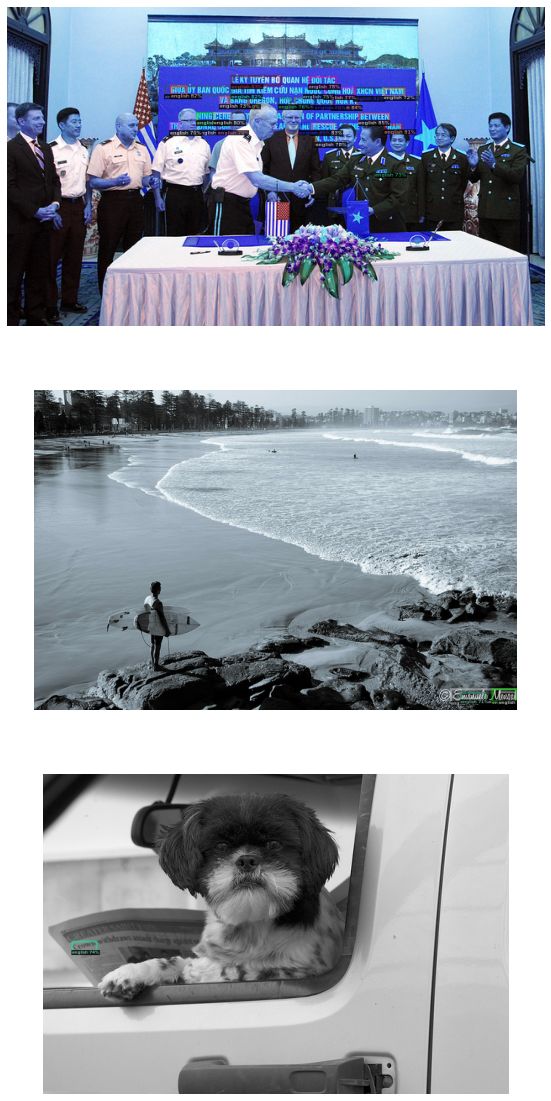

In [33]:
from detectron2.utils.visualizer import ColorMode
import skimage.io as io
#dataset_dicts = get_coco_dict("/coco/val2014")
imgIds = ct.getImgIds(imgIds=ct.val, catIds=[('legibility','legible')])
plt.figure(figsize=(20,20))
for d in range(3):    
    #im = cv2.imread(d["file_name"])
    img = ct.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
    im = cv2.imread('/coco/train2014/'+img['file_name'])
    #plt.imshow(im)
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=coco_text_metadata, 
                   scale=1,
                   instance_mode=ColorMode.IMAGE   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.subplot(3,1,d+1)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis("off")
plt.show()